# Bias types (Kilosort 2)

author: steeve.laquitaine@epfl.ch  
last modified: 13-02-2024
status: OK  
regression: None  

Purpose: Characterize and quantify ground truth sorting quality and biases from matching with best matching sorted units



### Setup

Create or activate env `npx_10m_384ch_unit_classes`

In [6]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns 
import spikeinterface as si
import copy
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(proj_path)

from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object, match_sorted_to_true_neuropixels_2023_02_19
from src.nodes.utils import get_config
from src.nodes.postpro.feateng import (add_firing_rates)
from src.nodes.postpro import spikestats

# set classification parameters
LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot" (sparse units)
DET_THRESH = 0.8
CHANCE_THRESH = 0.1

# buccino
data_conf, param_conf = get_config("buccino_2020", "2020").values()
SORTING_PATH_b = data_conf["sorting"]["sorters"]["kilosort2"]["output"]
GT_SORTING_PATH_b = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_b = data_conf["recording"]["output"]
SORTING_PATH_b = data_conf["sorting"]["sorters"]["kilosort2"]["output"]

# silico marques
data_conf, param_conf = get_config("silico_neuropixels", "2023_10_18").values()
SORTING_PATH_m = data_conf["sorting"]["sorters"]["kilosort2"]["output"]
GT_SORTING_PATH_m = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_m = data_conf["recording"]["output"]
SORTING_PATH_m = data_conf["sorting"]["sorters"]["kilosort2"]["output"]

# silico horvath
data_conf, param_conf = get_config("silico_horvath", "concatenated/probe_1").values()
SORTING_PATH_h = data_conf["sorting"]["sorters"]["kilosort2"]["output"]
GT_SORTING_PATH_h = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
RECORDING_PATH_h = data_conf["recording"]["output"]
SORTING_PATH_h = data_conf["sorting"]["sorters"]["kilosort2"]["output"]

# # silico stimulus (failed)
# data_conf, param_conf = get_config("silico_neuropixels", "stimulus").values()
# SORTING_PATH_e = data_conf["sorting"]["sorters"]["kilosort2"]["output"]
# GT_SORTING_PATH_e = data_conf["sorting"]["simulation"]["ground_truth"]["output"]
# RECORDING_PATH_e = data_conf["recording"]["output"]
# SORTING_PATH_e = data_conf["sorting"]["sorters"]["kilosort2"]["output"]


# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (1,1)
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.2
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-02-15 14:30:31,850 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-15 14:30:32,060 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-02-15 14:30:32,066 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-15 14:30:32,215 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-02-15 14:30:32,227 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-15 14:30:32,312 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Define custom functions

In [4]:
def format_agreement_matrix(MatchingObject):

    # get sorted x true units' agreement scores
    overmerging_matx = MatchingObject.agreement_scores.T

    # sort each row such that the row with the highest score be first, while column order stays unchanged
    argmax = overmerging_matx.T.idxmax().to_frame()
    max = overmerging_matx.T.max()
    descending_ix = np.argsort(max)[::-1]
    overmerging_matx_2 = overmerging_matx.iloc[descending_ix]

    # repeat for columns, row order stays auntouched
    argmax = overmerging_matx_2.idxmax().to_frame()
    max = overmerging_matx_2.max()
    descending_ix = np.argsort(max)[::-1]
    return overmerging_matx_2.iloc[:, descending_ix]


def classify_true_unit_biases(overmerging_matx_2, det_thresh, chance):

    # create masks
    mask_above_det = overmerging_matx_2 >= det_thresh
    mask_below_chance = overmerging_matx_2 <= chance
    mask_in_between = np.logical_and(
        overmerging_matx_2 < det_thresh, overmerging_matx_2 > chance
    )
    mask_entirely_missed = overmerging_matx_2 == 0

    # implement tree to classify ground truths
    # find ground truth (cols) with one mask_above_det=True and other mask_below_chance = True

    gt_classes = []
    df = pd.DataFrame()

    # loop over ground truth units
    for gt_i in range(overmerging_matx_2.shape[1]):

        # check if that ground truth has a single sorted unit
        # with an agreement score above detection threshold
        if any(mask_above_det.iloc[:, gt_i]):

            # get this ground truth detection stata
            is_detected = mask_above_det.iloc[:, gt_i]
            detected_loc = np.where(is_detected)[0]
            detected_ix = is_detected.index[detected_loc]

            # get other cells
            other_cells_ix = is_detected.drop(index=detected_ix).index

            # get this ground truth below chance stata
            is_below_chance = mask_below_chance.iloc[:, gt_i]

            # check if all other sorted units are below chance
            if all(is_below_chance.loc[other_cells_ix]):
                gt_classes.append("well detected")

            # if another unit has an agreement score
            # above chance level, it is: well detected + correlated unit
            else:
                gt_classes.append("well detected, correlated")

        # case where ground truth matches only one sorted unit
        # with a score b/w detection and chance and
        # other units below chance
        # no score are above detection
        elif (sum(mask_in_between.iloc[:, gt_i]) == 1) and (
            any(mask_above_det.iloc[:, gt_i]) == False
        ):
            gt_classes.append("poorly detected")

        # case a true unit is associated is a sorted unit with score
        # between detection and chance that is associated with other
        # true units with scores between detection and chances
        elif sum(mask_in_between.iloc[:, gt_i]) > 1:
            gt_classes.append("oversplit")

        # check that all sorted units have scores below
        # chance
        elif all(mask_below_chance.iloc[:, gt_i]):
            if all(mask_entirely_missed.iloc[:, gt_i]):
                gt_classes.append("missed")
            else:
                gt_classes.append("below chance")

    # Detect overmerged units and combinations -------------

    # if one of its sorted units with score between
    # detection and chance has also a score between
    # detection and chance with another true unit
    # the true unit is overmerged (with another true unit)
    true_units_loc = np.where(mask_in_between.sum(axis=0) >= 1)[0]
    true_units = mask_in_between.columns[true_units_loc]
    gt_overmerged = dict()

    for gt_i in range(len(true_units_loc)):
        target_true_units_mx = mask_in_between.iloc[:, true_units_loc]
        sorted_u = np.where(target_true_units_mx.iloc[:, gt_i])[0]

        # check overmerged (that sorted unit merges other true units)
        if any(mask_in_between.iloc[sorted_u, :].sum(axis=1) > 1):
            overmerged_bool = mask_in_between.iloc[sorted_u, :].sum(axis=1) > 1
            overmerging_sorted = overmerged_bool.index[
                np.where(overmerged_bool)[0]
            ].to_list()
            gt_overmerged[true_units[gt_i]] = overmerging_sorted

    # what other biases do overmerged units have?
    all_true_units = overmerging_matx_2.columns
    gt_classes_df = pd.DataFrame(data=gt_classes, index=all_true_units.to_list())
    print(
        "combination of biases:", np.unique(gt_classes_df.loc[gt_overmerged.keys(), :])
    )

    # label combination of biases
    gt_classes_df.loc[gt_overmerged.keys(), :] = gt_classes_df.loc[
        gt_overmerged.keys(), :
    ].apply(lambda x: x + ", overmerged")

    # poorly detected + overmerged units are poorly detected because overmerged so simply overmerged
    gt_classes_df[gt_classes_df == "poorly detected, overmerged"] = "overmerged"
    return gt_classes_df


def create_true_biases_df(true_biases_series):

    # format dataframe to plot
    bias_types = [
        "well detected",
        "well detected, correlated",
        "well detected, correlated, overmerged",
        "poorly detected",
        "overmerged",
        "oversplit",
        "oversplit, overmerged",
        "below chance",
        "missed",
    ]

    # count each bias
    count_by_class = dict(Counter(true_biases_series.values.squeeze().tolist()))

    # fill up count per bias
    for key_k in bias_types:
        try:
            count_by_class[key_k]
        except:
            count_by_class[key_k] = 0

    # order by "bias_types"
    reordered = {k: count_by_class[k] for k in bias_types}

    # create table
    biases_ratio_df = pd.DataFrame(
        {"cell_count": list(reordered.values())}, index=list(reordered.keys())
    )
    return biases_ratio_df


def plot_biases(axis, biases_count: pd.DataFrame):

    # set colors for combination of biases
    oversplit_plus_overmerged = np.array([[0.6, 0.9, 0.6], [0, 0.7, 1]]).mean(axis=0)
    well_detected_plus_correlated_units_plus_overmerged = np.array(
        [[1, 0, 0], [0, 0.7, 1]]
    ).mean(axis=0)

    # set all colors
    colors = [
        [0.7, 0.1, 0.1],  # "well_detected" (strong red)
        [1, 0, 0],  # "well_detected_plus_correlated_units" (red)
        well_detected_plus_correlated_units_plus_overmerged,
        [1, 0.85, 0.85],  # "poorly_detected" (pink)
        [0, 0.7, 1],  # "overmerged" (green)
        [0.6, 0.9, 0.6],  # "oversplit" (blue)
        oversplit_plus_overmerged,
        [0.95, 0.95, 0.95],  # "below chance"
        "k",  # "missed"
    ]

    biases_ratio = biases_count / biases_count.sum()

    # plot
    ax = (biases_ratio).T.plot.bar(
        ax=axis,
        stacked=True,
        color=colors,
        width=0.9,
        edgecolor=[0.5, 0.5, 0.5],
        linewidth=0.2,
    )

    # set axis legend
    ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_visible(False)
    ax.set_xticklabels(biases_ratio.columns, rotation=45, ha="right")
    ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

    ax.legend(
        biases_count.index,
        ncol=1,
        loc="lower left",
        bbox_to_anchor=(1, 0),
        frameon=False,
        handletextpad=0.6,
    )

    plt.tight_layout()
    return axis


def plot_heatmap(overmerging_matx_2):

    # plot
    # fig, axis = plt.subplots(1, 1, figsize=(2, 10))

    # plot agreement matrix
    mx_to_plot = overmerging_matx_2.iloc[:500, :500].values
    fig, axis = plt.subplots(figsize=(6, 4))

    ax = sns.heatmap(
        mx_to_plot,
        cmap="jet",
        cbar_kws={"shrink": 0.5},
        yticklabels=False,
        xticklabels=False,
    )
    plt.xlabel("true units")
    plt.ylabel("sorted units")
    ax.set_aspect("equal")


def classify_sorted_unit_biases(agreem_mx):

    # note: with this approach (BEST matching approach), the same sorted unit can be paired with more than one true unit
    # we only keep the pairings with highest agreement scores
    # true-sorted unit pairing
    pairing = agreem_mx.T.idxmax(axis=1)
    pairing = pairing.to_frame()
    pairing.columns = ["sorted"]

    # add agreement score
    accuracy = agreem_mx.T.max(axis=1)
    pairing["accuracy"] = accuracy

    # check if the only sorted unit paired with this true unit
    sorted_ids = agreem_mx.index

    df = copy.copy(pairing.iloc[0, :].to_frame().T)
    false_positives = []

    # else keep the pairing with highest agreement score
    # loop over all sorted single unit units
    for ix in range(len(sorted_ids)):
        # case the sorted unit was paired with a ground truth unit
        if any(pairing["sorted"] == sorted_ids[ix]):
            sorted_pairings = pairing[pairing["sorted"] == sorted_ids[ix]].sort_values(
                by="accuracy", ascending=False
            )
            # take max pairing (first row)
            df = pd.concat([df, sorted_pairings.iloc[0, :].to_frame().T])
        else:
            # case the sorted unit was paired with none of the ground truth units
            false_positives.append(sorted_ids[ix])

    df = df[1:]
    df["sorted"] = df["sorted"].astype(int)

    # count biases
    n_good = sum(df["accuracy"] >= DET_THRESH)
    n_poor = sum((df["accuracy"] >= CHANCE_THRESH) & (df["accuracy"] < DET_THRESH))
    n_below_chance = sum((df["accuracy"] > 0) & (df["accuracy"] < CHANCE_THRESH))
    n_false_pos = len(false_positives)

    # sanity check
    assert n_good + n_poor + n_below_chance + n_false_pos == len(
        sorted_ids
    ), "They must match"
    return {
        "n_good": n_good,
        "n_poor": n_poor,
        "n_below_chance": n_below_chance,
        "n_false_pos": n_false_pos,
    }

### Get sorted x true agreement matrix

In [7]:
# takes 2 min

# get true/sorted matching object
MatchingObject_b = get_SpikeInterface_matching_object(GT_SORTING_PATH_b, SORTING_PATH_b)
MatchingObject_m = get_SpikeInterface_matching_object(GT_SORTING_PATH_m, SORTING_PATH_m)
MatchingObject_h = get_SpikeInterface_matching_object(GT_SORTING_PATH_h, SORTING_PATH_h)
# MatchingObject_e = get_SpikeInterface_matching_object(GT_SORTING_PATH_e, SORTING_PATH_e)

We sort each row in descending order. The columns are not labelled as the raw ground truth anymore but become labelled as best match ground truth to the worst match.

In [8]:
agreem_mx_b = format_agreement_matrix(MatchingObject_b)
agreem_mx_m = format_agreement_matrix(MatchingObject_m)
agreem_mx_h = format_agreement_matrix(MatchingObject_h)
# agreem_mx_e = format_agreement_matrix(MatchingObject_e)

### Plot biases (matching only the best matching sorted single units)

Filter the sorted single units

In [9]:
# filter the sorted single units

# buccino
Sorting = si.load_extractor(SORTING_PATH_b)
agreem_mx_b = agreem_mx_b.loc[
    Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"], :
]

# marques
Sorting = si.load_extractor(SORTING_PATH_m)
agreem_mx_m = agreem_mx_m.loc[
    Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"], :
]

# horvath
Sorting = si.load_extractor(SORTING_PATH_h)
agreem_mx_h = agreem_mx_h.loc[
    Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"], :
]

# # evoked
# Sorting = si.load_extractor(SORTING_PATH_e)
# agreem_mx_e = agreem_mx_e.loc[
#     Sorting.unit_ids[Sorting.get_property("KSLabel") == "good"], :
# ]

Plot

In [10]:
agreem_mx_m

,3558393,680496,3887809,367098,3810046,1653016,3443482,1527208,796411,1429004,...,833045,836784,839991,864100,3641500,3644907,3645158,559694,3471826,1688572
2,0.000000,0.000853,0.000889,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000806,0.000000,0.0,0.000000,0.000000,0.000730,0.000000,0.000000,0.001376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.001469,0.000789,0.000532,0.0,0.000000,0.000350,0.002036,0.000348,0.000000,0.000304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000548,0.000899,0.000459,0.0,0.000000,0.000000,0.000850,0.000000,0.000725,0.001169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.001141,0.000768,0.000777,0.0,0.000000,0.000000,0.000743,0.000000,0.000000,0.000294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
504,0.001932,0.001004,0.000680,0.0,0.000000,0.000000,0.000962,0.000000,0.001399,0.000404,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
511,0.000000,0.001666,0.000000,0.0,0.000000,0.001172,0.001035,0.000000,0.000000,0.000775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
514,0.000000,0.001645,0.001677,0.0,0.000000,0.000000,0.000390,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


combination of biases: ['well detected, correlated']
combination of biases: ['poorly detected']
combination of biases: ['poorly detected']


/tmp/ipykernel_279623/1308606798.py:208: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


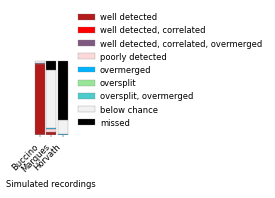

In [14]:
# takes 2 secs

# record agreement matrices for each dataset
agreem_mxs = [agreem_mx_b, agreem_mx_m, agreem_mx_h]
agreem_names = ["Buccino", "Marques", "Horvath"]

df = pd.DataFrame()

for ix, mx_i in enumerate(agreem_mxs):

    # classify sorting biases for this dataset
    bias_labels = classify_true_unit_biases(mx_i, DET_THRESH, CHANCE_THRESH)

    # calculate proportions of biases for this dataset
    biases_ratio_df = create_true_biases_df(bias_labels)
    df[agreem_names[ix]] = biases_ratio_df["cell_count"].values

df.index = biases_ratio_df.index

# plot
fig, axis = plt.subplots(1, 1, figsize=(0.5, 1))
axis = plot_biases(axis, df)
axis.set_xlabel("Simulated recordings")

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/figures/3_bias/svg/truth_sorting_accuracy_and_biases_ks2.svg",
    **savefig_cfg,
)

In [12]:
df

,Buccino,Marques,Horvath
well detected,240,47,0
"well detected, correlated",0,4,0
"well detected, correlated, overmerged",3,0,0
poorly detected,0,46,0
overmerged,0,19,2
oversplit,0,1,0
"oversplit, overmerged",0,0,0
below chance,7,1029,56
missed,0,164,229


## A simple description of sorted units as "good", "poor", "below chance" or "false positive"

This description is only based on the unit sorting accuracy with its best matching ground truth unit



/tmp/ipykernel_279623/1070622966.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


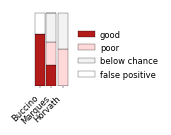

In [15]:
# set all colors
colors = [
    [0.7, 0.1, 0.1],  # "good" (strong red)
    [1, 0.85, 0.85],  # "poor" (pink)
    [0.95, 0.95, 0.95],  # "below chance"
    "w",  # "false positive"
]

# count sorted unit biases for each dataset
agreem_names = ["Buccino", "Marques", "Horvath"]

df2 = pd.DataFrame()

for ix in range(len(agreem_names)):
    out = classify_sorted_unit_biases(agreem_mxs[ix])
    df2[agreem_names[ix]] = [
        out["n_good"],
        out["n_poor"],
        out["n_below_chance"],
        out["n_false_pos"],
    ]
df2.index = ["good", "poor", "below chance", "false positive"]
df2_ratio = df2 / df2.sum()

fig, axis = plt.subplots(1, 1, figsize=(0.5, 1))
ax = (df2_ratio).T.plot.bar(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.9,
    edgecolor=[0, 0, 0],
    linewidth=0.2,
)


# set axis legend
ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xticklabels(df2_ratio.columns, rotation=45, ha="right")
ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

ax.legend(
    df2.index,
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
    frameon=False,
    handletextpad=0.6,
)

plt.tight_layout()

# save figures
plt.savefig(
    "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/figures/3_bias/svg/sorted_unit_biases_ks2.svg",
    **savefig_cfg,
)

### SUPPLREMENTARY: For a comprehensive descriptions of biases for ground truth and sorted units

In [ ]:
overmerging_matx_2 = agreem_mx_m
det_thresh = 0.8
chance = 0.1

# create masks
mask_above_det = overmerging_matx_2 >= det_thresh
mask_below_chance = overmerging_matx_2 <= chance
mask_in_between = np.logical_and(
    overmerging_matx_2 < det_thresh, overmerging_matx_2 > chance
)
mask_entirely_missed = overmerging_matx_2 == 0

# implement tree to classify ground truths
# find ground truth (cols) with one mask_above_det=True and other mask_below_chance = True

gt_classes = []
df = pd.DataFrame(
    data=np.array([[0], [0], [0], [0]]).T,
    columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
)

# loop over ground truth units
for gt_i in range(overmerging_matx_2.shape[1]):

    # check if that ground truth has a single sorted unit
    # with an agreement score above detection threshold
    if any(mask_above_det.iloc[:, gt_i]):

        # get this ground truth detection stata
        is_detected = mask_above_det.iloc[:, gt_i]
        detected_loc = np.where(is_detected)[0]
        detected_id = is_detected.index[detected_loc]

        # get other correlated unit ids
        other_sorted_unit_ids = is_detected.drop(index=detected_id).index

        # get this ground truth below chance stata
        is_below_chance = mask_below_chance.iloc[:, gt_i]

        # check if all other sorted units are below chance
        if all(is_below_chance.loc[other_sorted_unit_ids]):
            gt_classes.append("well detected")

            # pair true and sorted units
            df2 = pd.DataFrame(
                data=np.array(
                    [
                        [overmerging_matx_2.columns[gt_i]],
                        [detected_id[0]],
                        ["well detected"],
                        ["good"],
                    ]
                ).T,
                columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
            )
            df = pd.concat([df, df2])

        # if another unit has an agreement score
        # above chance level, it is: well detected + correlated unit
        else:
            gt_classes.append("well detected, correlated")

            # pair true and the well detected sorted unit
            df2 = pd.DataFrame(
                data=np.array(
                    [
                        [overmerging_matx_2.columns[gt_i]],
                        [detected_id[0]],
                        ["well detected, correlated"],
                        ["good"],
                    ]
                ).T,
                columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
            )
            df = pd.concat([df, df2])

            # pair true and the other redundant sorted unit
            n_redundants = len(other_sorted_unit_ids.tolist())
            df2 = pd.DataFrame(
                data=np.array(
                    [
                        n_redundants * [overmerging_matx_2.columns[gt_i]],
                        other_sorted_unit_ids.tolist(),
                        n_redundants * ["poorly detected"],
                        n_redundants * ["redundant"],
                    ]
                ).T,
                columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
            )
            df = pd.concat([df, df2])

    # case where ground truth matches only one sorted unit
    # with a score b/w detection and chance and
    # other units below chance
    # no scores are above detection
    elif (sum(mask_in_between.iloc[:, gt_i]) == 1) and (
        any(mask_above_det.iloc[:, gt_i]) == False
    ):
        gt_classes.append("poorly detected")

        # pair units
        unit_id = overmerging_matx_2.index[
            np.where(mask_in_between.iloc[:, gt_i] == 1)[0][0]
        ]
        df2 = pd.DataFrame(
            data=np.array(
                [
                    [overmerging_matx_2.columns[gt_i]],
                    [unit_id],
                    ["poorly detected"],
                    ["poor unit"],
                ]
            ).T,
            columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
        )
        df = pd.concat([df, df2])

    # case a true unit is associated is a sorted unit with score
    # between detection and chance that is associated with other
    # true units with scores between detection and chances
    elif sum(mask_in_between.iloc[:, gt_i]) > 1:
        gt_classes.append("oversplit")

        # pair units
        unit_ids = overmerging_matx_2.index[
            np.where(mask_in_between.iloc[:, gt_i])[0].tolist()
        ].tolist()
        n_oversplitters = len(unit_ids)

        df2 = pd.DataFrame(
            data=np.array(
                [
                    n_oversplitters * [overmerging_matx_2.columns[gt_i]],
                    unit_ids,
                    n_oversplitters * ["oversplit"],
                    n_oversplitters * ["oversplitters"],
                ]
            ).T,
            columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
        )
        df = pd.concat([df, df2])

    # check that all sorted units have scores below
    # chance
    elif all(mask_below_chance.iloc[:, gt_i]):
        if all(mask_entirely_missed.iloc[:, gt_i]):
            gt_classes.append("missed")

            # pair units
            df2 = pd.DataFrame(
                data=np.array(
                    [
                        [overmerging_matx_2.columns[gt_i]],
                        [np.nan],
                        ["missed"],
                        [np.nan],
                    ]
                ).T,
                columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
            )
            df = pd.concat([df, df2])
        else:
            gt_classes.append("below chance")
            unit_ids = overmerging_matx_2.index[
                np.where(
                    (overmerging_matx_2.iloc[:, gt_i] <= chance)
                    * (overmerging_matx_2.iloc[:, gt_i] > 0)
                )[0]
            ].tolist()
            n_below_chance = len(unit_ids)

            df2 = pd.DataFrame(
                data=np.array(
                    [
                        n_below_chance * [overmerging_matx_2.columns[gt_i]],
                        unit_ids,
                        n_below_chance * ["below chance"],
                        n_below_chance * ["below chance"],
                    ]
                ).T,
                columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
            )
            df = pd.concat([df, df2])


# Detect overmerged units and combinations -------------

# if one of its sorted units with score between
# detection and chance has also a score between
# detection and chance with another true unit
# the true unit is overmerged (with another true unit)
true_units_loc = np.where(mask_in_between.sum(axis=0) >= 1)[0]
true_units = mask_in_between.columns[true_units_loc]
gt_overmerged = dict()

for gt_i in range(len(true_units_loc)):
    target_true_units_mx = mask_in_between.iloc[:, true_units_loc]
    sorted_u = np.where(target_true_units_mx.iloc[:, gt_i])[0]

    # check overmerged (that sorted unit merges other true units)
    if any(mask_in_between.iloc[sorted_u, :].sum(axis=1) > 1):
        overmerged_bool = mask_in_between.iloc[sorted_u, :].sum(axis=1) > 1
        overmerging_sorted = overmerged_bool.index[
            np.where(overmerged_bool)[0]
        ].to_list()
        gt_overmerged[true_units[gt_i]] = overmerging_sorted

# what other biases do overmerged units have?
all_true_units = overmerging_matx_2.columns
gt_classes_df = pd.DataFrame(data=gt_classes, index=all_true_units.to_list())
print("combination of biases:", np.unique(gt_classes_df.loc[gt_overmerged.keys(), :]))

# label combination of biases
gt_classes_df.loc[gt_overmerged.keys(), :] = gt_classes_df.loc[
    gt_overmerged.keys(), :
].apply(lambda x: x + ", overmerged")

# poorly detected + overmerged units are poorly detected because overmerged so simply overmerged
gt_classes_df[gt_classes_df == "poorly detected, overmerged"] = "overmerged"
df = df[1:]

combination of biases: ['oversplit' 'poorly detected']


In [203]:
df

,ground truth,sorted,ground truth bias,sorted bias
0,1527208,99,below chance,below chance
1,1527208,117,below chance,below chance
2,1527208,124,below chance,below chance
3,1527208,164,below chance,below chance
4,1527208,198,below chance,below chance
...,...,...,...,...
0,3547327,nan,missed,nan
0,1509317,nan,missed,nan
0,1514245,nan,missed,nan
0,2696195,nan,missed,nan


### A sorted unit can show several biases (with different ground truth units)

In [204]:
ix = 20

sorted_ids = df["sorted"].unique()
df[df["sorted"] == sorted_ids[ix]]["sorted bias"].unique()

array(['below chance', 'redundant', 'poor unit'], dtype=object)